<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/daging_sapi2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [ ]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [ ]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [ ]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f0b25147e50>)

In [ ]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [ ]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [ ]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.daging_sapi_kualitas_2.values
date = dataset.index

## Train test val split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


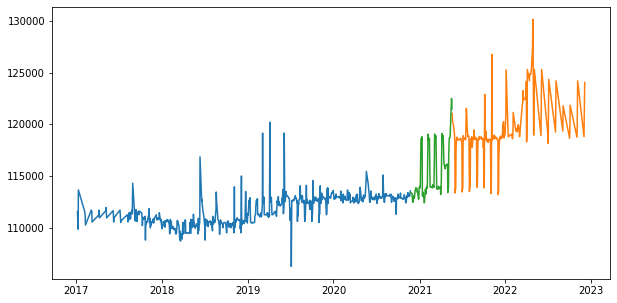

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [ ]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

## model 

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


### SGD

In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 18s 44ms/step - loss: 0.2043 - mae: 0.4506 - mape: 93.9519 - val_loss: 0.1786 - val_mae: 0.3491 - val_mape: 75.1973
Epoch 2/30
44/44 [==============================] - 1s 20ms/step - loss: 0.1404 - mae: 0.3728 - mape: 77.6657 - val_loss: 0.1354 - val_mae: 0.2862 - val_mape: 56.1565
Epoch 3/30
44/44 [==============================] - 1s 18ms/step - loss: 0.0948 - mae: 0.3061 - mape: 63.7305 - val_loss: 0.1061 - val_mae: 0.2555 - val_mape: 56.7569
Epoch 4/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0638 - mae: 0.2504 - mape: 52.0394 - val_loss: 0.0870 - val_mae: 0.2333 - val_mape: 59.3818
Epoch 5/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0428 - mae: 0.2044 - mape: 42.4273 - val_loss: 0.0747 - val_mae: 0.2153 - val_mape: 61.5075
Epoch 6/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0286 - mae: 0.1661 - mape: 34.4083 - val_loss: 0.0671 - val_mae: 0.2005 - val_mape: 63.25

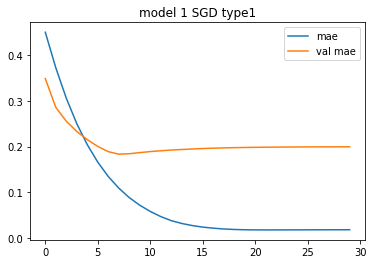

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

In [ ]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
test_sapi2_ = scal_range.fit_transform(forecast.reshape(-1, 1))

131/131 [==============================] - 2s 7ms/step
2216.1016 1.8324207 3086.2287666341263


,date,actual,prediction
0,2021-05-20,121050,117018.851562
1,2021-05-21,120300,117021.578125
2,2021-05-24,120050,117038.054688
3,2021-05-25,119900,117059.914062
4,2021-05-27,119500,117081.968750
...,...,...,...
229,2022-11-02,119350,118030.007812
230,2022-11-03,121850,118021.578125
231,2022-11-04,124200,118017.304688
232,2022-12-01,118800,118007.617188


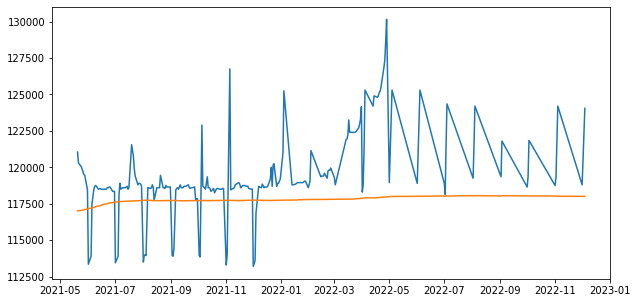

In [ ]:
prediction = forecast_predict(model, test_sapi2_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_sapi2 = pd.DataFrame()
data_new_sapi2['date'] = y_test
data_new_sapi2['actual'] = x_test
data_new_sapi2['prediction'] = data_result
data_new_sapi2.to_csv('dagingsapi2_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_sapi2.date, data_new_sapi2.actual)
plt.plot(data_new_sapi2.date, data_new_sapi2.prediction)
data_new_sapi2

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0087 - mae: 0.0723 - mape: 550676.1250 - val_loss: 0.0565 - val_mae: 0.1937 - val_mape: 82.7162
Epoch 2/30
718/718 [==============================] - 7s 9ms/step - loss: 0.0078 - mae: 0.0675 - mape: 550409.3125 - val_loss: 0.0564 - val_mae: 0.1933 - val_mape: 82.1579
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0077 - mae: 0.0660 - mape: 531346.1250 - val_loss: 0.0564 - val_mae: 0.1931 - val_mape: 81.8864
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0076 - mae: 0.0665 - mape: 584273.5000 - val_loss: 0.0564 - val_mae: 0.1932 - val_mape: 81.8786
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0075 - mae: 0.0651 - mape: 572702.0000 - val_loss: 0.0563 - val_mae: 0.1932 - val_mape: 81.8926
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0075 - mae: 0.0647 - mape: 542283.4375 - val_loss: 0.0563 - val_

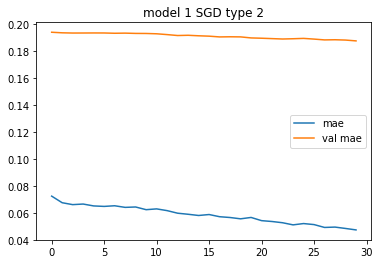

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
2218.9233 1.837192 2997.6153856023625


,date,actual,prediction
0,2021-05-20,121050,117018.851562
1,2021-05-21,120300,117021.578125
2,2021-05-24,120050,117038.054688
3,2021-05-25,119900,117059.914062
4,2021-05-27,119500,117081.968750
...,...,...,...
229,2022-11-02,119350,118030.007812
230,2022-11-03,121850,118021.578125
231,2022-11-04,124200,118017.304688
232,2022-12-01,118800,118007.617188


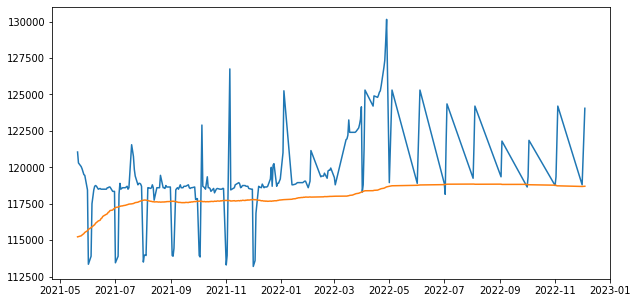

In [ ]:
win_size1 = 60
test_sapi2_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_sapi2_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_sapi2_1 = pd.DataFrame()
data_new_sapi2_1['actual'] = x_test
data_new_sapi2_1['prediction'] = data_result_1
data_new_sapi2_1.to_csv('dagingsapi2_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_sapi2_1.actual)
plt.plot(y_test, data_new_sapi2_1.prediction)
data_new_sapi2

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0036 - mae: 0.0307 - mape: 1122931.6250 - val_loss: 0.0565 - val_mae: 0.1872 - val_mape: 73.2240
Epoch 2/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0036 - mae: 0.0309 - mape: 1119336.0000 - val_loss: 0.0565 - val_mae: 0.1872 - val_mape: 73.1586
Epoch 3/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0036 - mae: 0.0310 - mape: 1117279.1250 - val_loss: 0.0565 - val_mae: 0.1871 - val_mape: 73.0099
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0036 - mae: 0.0308 - mape: 1118317.2500 - val_loss: 0.0565 - val_mae: 0.1872 - val_mape: 73.0966
Epoch 5/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0036 - mae: 0.0309 - mape: 1119208.2500 - val_loss: 0.0565 - val_mae: 0.1872 - val_mape: 73.1852
Epoch 6/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0036 - mae: 0.0309 - mape: 1118964.1250 - val_loss: 0.0565 - val_

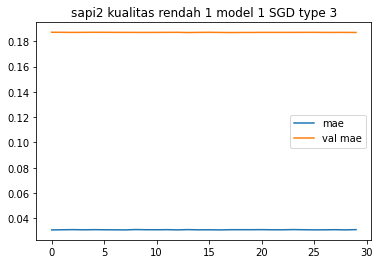

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('sapi2 kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
2225.6904 1.8428527 3001.0514823974613


,actual,prediction
0,121050,115194.843750
1,120300,115209.984375
2,120050,115265.320312
3,119900,115320.695312
4,119500,115417.023438
...,...,...
229,119350,118779.960938
230,121850,118735.531250
231,124200,118737.679688
232,118800,118693.593750


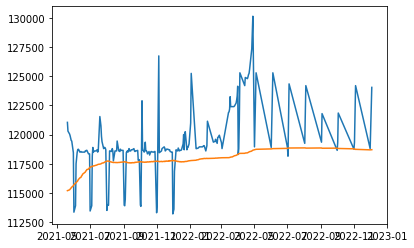

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_sapi2_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_sapi2_2 = pd.DataFrame()
# data_new_sapi21['date'] = date_test
data_new_sapi2_2['actual'] = x_test
data_new_sapi2_2['prediction'] = data_result_2
data_new_sapi2_2.to_csv('dagingsapi2_model1_sgd_type3.csv')

plt.plot(y_test, data_new_sapi2_2.actual)
plt.plot(y_test, data_new_sapi2_2.prediction)
data_new_sapi2_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 5s 39ms/step - loss: 0.2407 - mae: 0.4889 - mape: 101.9727 - val_loss: 0.1999 - val_mae: 0.3785 - val_mape: 86.1788
Epoch 2/30
44/44 [==============================] - 1s 19ms/step - loss: 0.1604 - mae: 0.3987 - mape: 83.1050 - val_loss: 0.1542 - val_mae: 0.3143 - val_mape: 63.8287
Epoch 3/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0789 - mae: 0.2744 - mape: 57.0994 - val_loss: 0.0880 - val_mae: 0.2342 - val_mape: 58.1558
Epoch 4/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0063 - mae: 0.0596 - mape: 12.3056 - val_loss: 0.0586 - val_mae: 0.1838 - val_mape: 65.8262
Epoch 5/30
44/44 [==============================] - 1s 19ms/step - loss: 8.8578e-04 - mae: 0.0183 - mape: 3.7402 - val_loss: 0.0600 - val_mae: 0.1855 - val_mape: 64.3195
Epoch 6/30
44/44 [==============================] - 1s 19ms/step - loss: 9.3557e-04 - mae: 0.0187 - mape: 3.8098 - val_loss: 0.0598 - val_mae: 0.1852 - val_mape:

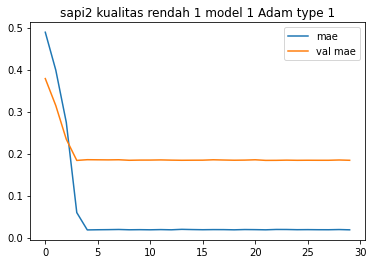

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('sapi2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
1977.1171 1.6404924 2737.267524375358


,actual,prediction
0,121050,114315.718750
1,120300,114298.875000
2,120050,114412.554688
3,119900,114482.648438
4,119500,114619.765625
...,...,...
229,119350,120282.929688
230,121850,120383.460938
231,124200,120225.187500
232,118800,120345.468750


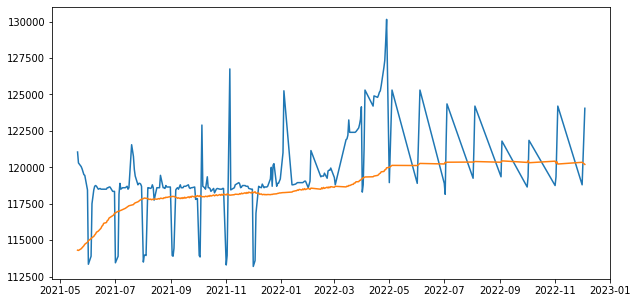

In [ ]:
prediction_a = forecast_predict(model_a, test_sapi2_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_sapi2_a = pd.DataFrame()
# data_new_sapi21['date'] = date_test
data_new_sapi2_a['actual'] = x_test
data_new_sapi2_a['prediction'] = data_result_a
data_new_sapi2_a.to_csv('dagingsapi2_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_sapi2_a.actual)
plt.plot(y_test, data_new_sapi2_a.prediction)
data_new_sapi2_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0047 - mae: 0.0398 - mape: 657876.2500 - val_loss: 0.0594 - val_mae: 0.1847 - val_mape: 65.3233
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0045 - mae: 0.0389 - mape: 586274.5625 - val_loss: 0.0609 - val_mae: 0.1875 - val_mape: 64.2475
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0044 - mae: 0.0386 - mape: 617596.6875 - val_loss: 0.0585 - val_mae: 0.1836 - val_mape: 66.2343
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0045 - mae: 0.0386 - mape: 641725.3750 - val_loss: 0.0598 - val_mae: 0.1852 - val_mape: 64.8867
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0045 - mae: 0.0383 - mape: 657055.4375 - val_loss: 0.0592 - val_mae: 0.1845 - val_mape: 65.3617
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0045 - mae: 0.0384 - mape: 637087.3750 - val_loss: 0.0582 - val_

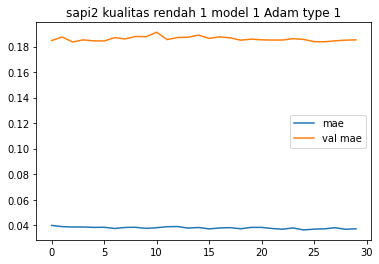

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('sapi2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
1947.5724 1.6179122 2666.0733298242194


,actual,prediction
0,121050,113772.687500
1,120300,113763.734375
2,120050,114040.765625
3,119900,114143.507812
4,119500,114424.789062
...,...,...
229,119350,120551.132812
230,121850,120383.320312
231,124200,120449.335938
232,118800,120389.539062


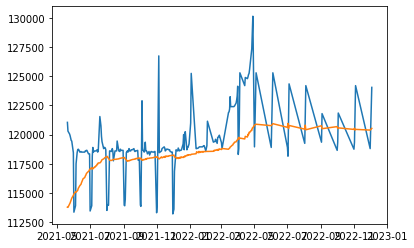

In [ ]:
prediction_a1 = forecast_predict(model_a, test_sapi2_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_sapi2_a1 = pd.DataFrame()
data_new_sapi2_a1['actual'] = x_test
data_new_sapi2_a1['prediction'] = data_result_a1
data_new_sapi2_a1.to_csv('dagingsapi2_model1_adam_type2.csv')

plt.plot(y_test, data_new_sapi2_a1.actual)
plt.plot(y_test, data_new_sapi2_a1.prediction)
data_new_sapi2_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0036 - mae: 0.0307 - mape: 1098612.7500 - val_loss: 0.0591 - val_mae: 0.1840 - val_mape: 62.4945
Epoch 2/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0036 - mae: 0.0307 - mape: 1125339.7500 - val_loss: 0.0594 - val_mae: 0.1844 - val_mape: 62.1724
Epoch 3/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0036 - mae: 0.0302 - mape: 1119052.6250 - val_loss: 0.0590 - val_mae: 0.1839 - val_mape: 62.4391
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0036 - mae: 0.0312 - mape: 1116201.1250 - val_loss: 0.0590 - val_mae: 0.1838 - val_mape: 62.3883
Epoch 5/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0035 - mae: 0.0306 - mape: 1098016.3750 - val_loss: 0.0593 - val_mae: 0.1842 - val_mape: 62.0825
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0036 - mae: 0.0305 - mape: 1091459.0000 - val_loss: 0.0584 - val_

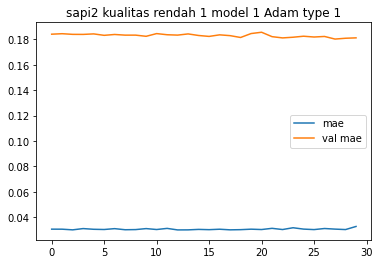

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('sapi2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
1966.7281 1.6305618 2811.5525959867796


,actual,prediction
0,121050,113951.523438
1,120300,113920.445312
2,120050,114202.296875
3,119900,114252.328125
4,119500,114518.468750
...,...,...
229,119350,119555.031250
230,121850,119345.046875
231,124200,119544.585938
232,118800,119433.890625


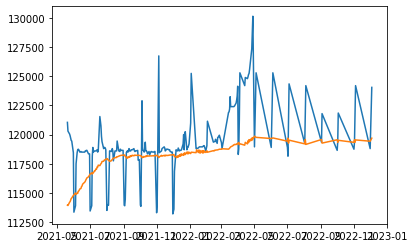

In [ ]:
prediction_a2 = forecast_predict(model_a, test_sapi2_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_sapi2_a2 = pd.DataFrame()
# data_new_sapi21['date'] = date_test
data_new_sapi2_a2['actual'] = x_test
data_new_sapi2_a2['prediction'] = data_result_a2
data_new_sapi2_a2.to_csv('dagingsapi2_model1_adam_type3.csv')

plt.plot(y_test, data_new_sapi2_a2.actual)
plt.plot(y_test, data_new_sapi2_a2.prediction)
data_new_sapi2_a2

## model 1

### Adam

In [ ]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
        LSTM(128, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=100, validation_data=val_step)

Epoch 1/100
44/44 [==============================] - 5s 44ms/step - loss: 0.0201 - mae: 0.0846 - mape: 17.6705 - val_loss: 0.0566 - val_mae: 0.1885 - val_mape: 75.7174
Epoch 2/100
44/44 [==============================] - 1s 21ms/step - loss: 9.8517e-04 - mae: 0.0201 - mape: 4.0884 - val_loss: 0.0571 - val_mae: 0.1876 - val_mape: 74.1148
Epoch 3/100
44/44 [==============================] - 1s 22ms/step - loss: 9.9996e-04 - mae: 0.0201 - mape: 4.0940 - val_loss: 0.0563 - val_mae: 0.1912 - val_mape: 79.4045
Epoch 4/100
44/44 [==============================] - 1s 22ms/step - loss: 0.0011 - mae: 0.0224 - mape: 4.5783 - val_loss: 0.0568 - val_mae: 0.1886 - val_mape: 75.5676
Epoch 5/100
44/44 [==============================] - 1s 22ms/step - loss: 0.0012 - mae: 0.0228 - mape: 4.6700 - val_loss: 0.0570 - val_mae: 0.1879 - val_mape: 74.4011
Epoch 6/100
44/44 [==============================] - 1s 21ms/step - loss: 0.0012 - mae: 0.0258 - mape: 5.3142 - val_loss: 0.0573 - val_mae: 0.1874 - val_map

17/17 [==============================] - 0s 6ms/step - loss: 0.0261 - mae: 0.1376 - mape: 29.6294


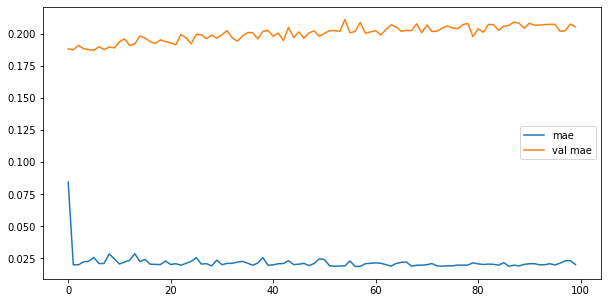

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_sapi2_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_sapi21 = pd.DataFrame()
data_new_sapi21['actual'] = x_test
data_new_sapi21['prediction'] = data_result1
data_new_sapi21.to_csv('dagingsapi2_model2_adam_type1.csv')

data_new_sapi21

131/131 [==============================] - 2s 7ms/step
2229.4941 1.8432176 3116.526913087708


,actual,prediction
0,121050,117507.398438
1,120300,117508.093750
2,120050,117512.937500
3,119900,117519.609375
4,119500,117531.312500
...,...,...
229,119350,117826.289062
230,121850,117808.250000
231,124200,117809.320312
232,118800,117798.117188


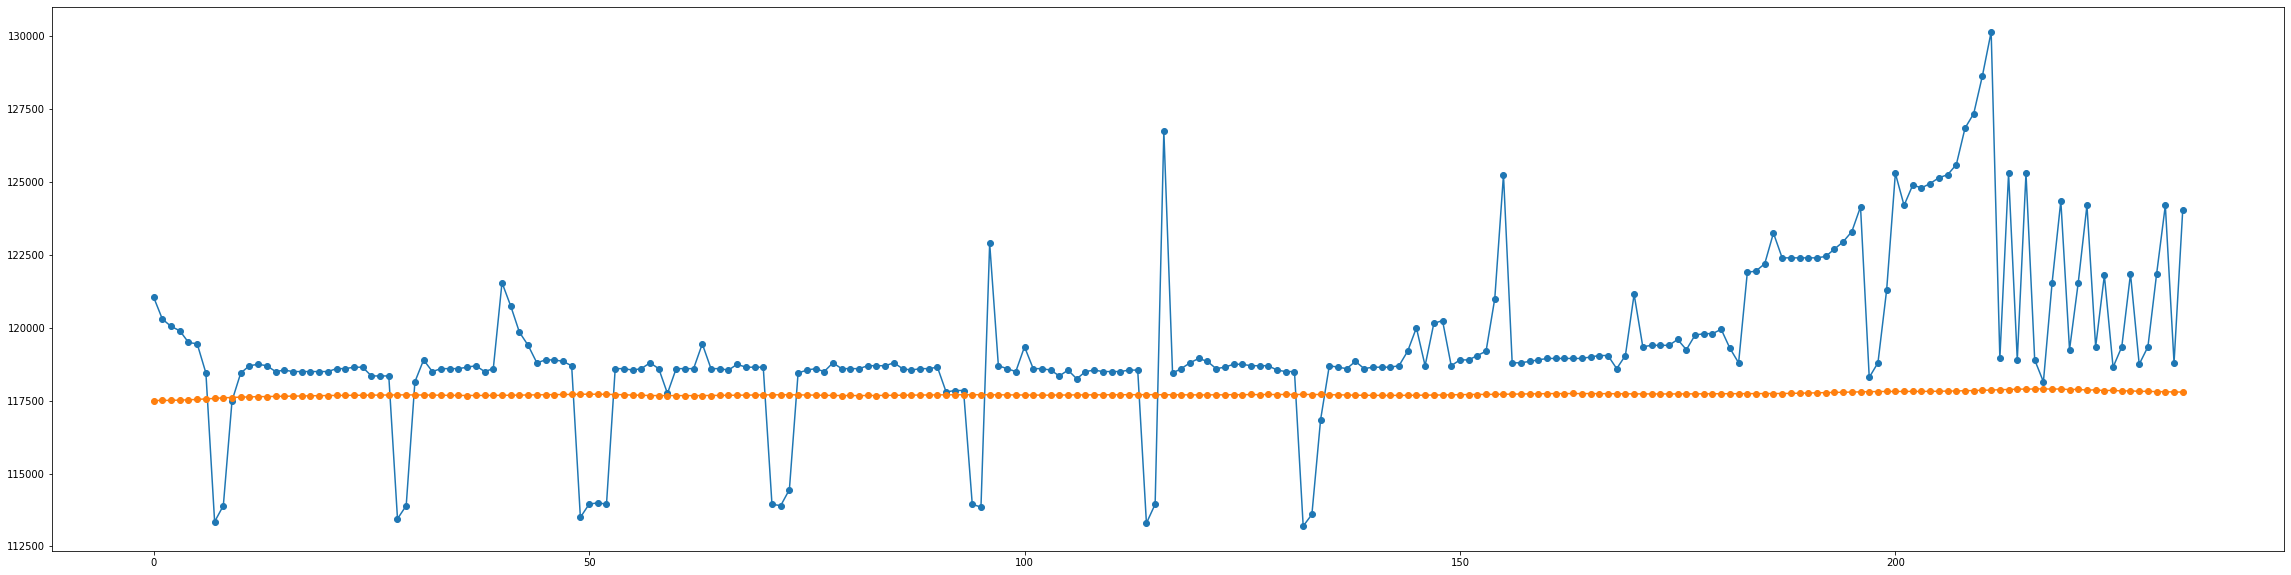

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_sapi21['actual'], '-o')
plt.plot(range(len(x_test)), data_new_sapi21['prediction'], '-o')

#### Type 2

In [ ]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0059 - mae: 0.0484 - mape: 582069.5000 - val_loss: 0.0594 - val_mae: 0.2036 - val_mape: 92.5148
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0055 - mae: 0.0459 - mape: 518158.7500 - val_loss: 0.0614 - val_mae: 0.2094 - val_mape: 97.1387
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0058 - mae: 0.0471 - mape: 649869.7500 - val_loss: 0.0608 - val_mae: 0.2079 - val_mape: 95.9834
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0061 - mae: 0.0485 - mape: 570502.2500 - val_loss: 0.0602 - val_mae: 0.2061 - val_mape: 94.5861
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0058 - mae: 0.0467 - mape: 585326.8125 - val_loss: 0.0597 - val_mae: 0.2044 - val_mape: 93.3033
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0058 - mae: 0.0471 - mape: 677744.5625 - val_loss: 0.0605 - val_

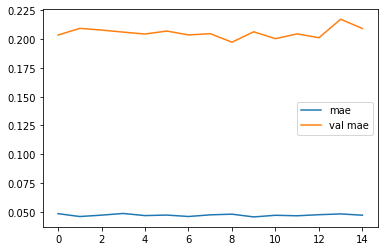

In [ ]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
2138.329 1.7670969 3116.526913087708


,actual,prediction
0,121050,117835.273438
1,120300,117835.273438
2,120050,117835.273438
3,119900,117835.273438
4,119500,117835.273438
...,...,...
229,119350,117839.460938
230,121850,117838.390625
231,124200,117838.804688
232,118800,117838.046875


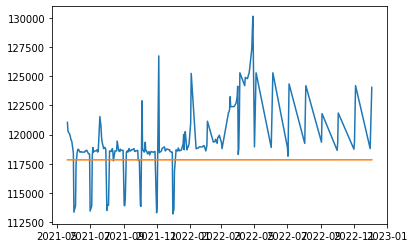

In [ ]:
prediction1_1 = forecast_predict(model1, test_sapi2_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_sapi21_1 = pd.DataFrame()
data_new_sapi21_1['actual'] = x_test
data_new_sapi21_1['prediction'] = data_result1_1
data_new_sapi21_1.to_csv('dagingsapi2_model2_adam_type2.csv')

plt.plot(y_test, data_new_sapi21_1.actual)
plt.plot(y_test, data_new_sapi21_1.prediction)
data_new_sapi21_1

#### Type 3

In [ ]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0040 - mae: 0.0350 - mape: 1108094.5000 - val_loss: 0.0583 - val_mae: 0.2001 - val_mape: 89.4807
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0040 - mae: 0.0352 - mape: 1116835.0000 - val_loss: 0.0593 - val_mae: 0.2033 - val_mape: 92.3232
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0040 - mae: 0.0351 - mape: 1120773.5000 - val_loss: 0.0586 - val_mae: 0.2011 - val_mape: 90.3641
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0040 - mae: 0.0357 - mape: 1130557.2500 - val_loss: 0.0589 - val_mae: 0.2023 - val_mape: 91.4410
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0040 - mae: 0.0348 - mape: 1115255.1250 - val_loss: 0.0587 - val_mae: 0.2015 - val_mape: 90.7228
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0040 - mae: 0.0349 - mape: 1115619.1250 - val_loss: 0.0589 - val_

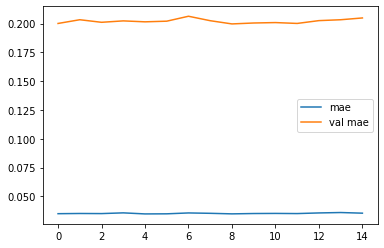

In [ ]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
2388.909 1.975244 3116.526913087708


,actual,prediction
0,121050,117534.914062
1,120300,117534.914062
2,120050,117534.914062
3,119900,117534.914062
4,119500,117534.914062
...,...,...
229,119350,117538.984375
230,121850,117537.937500
231,124200,117538.335938
232,118800,117537.609375


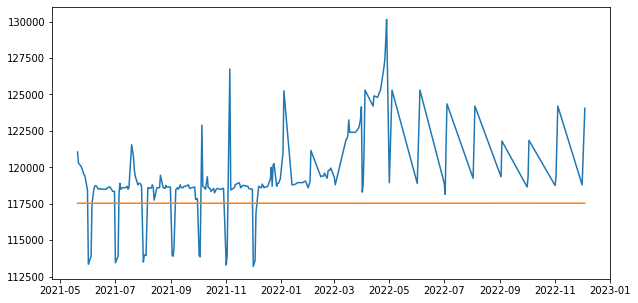

In [ ]:
prediction1_2 = forecast_predict(model1, test_sapi2_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_sapi21_2 = pd.DataFrame()
data_new_sapi21_2['actual'] = x_test
data_new_sapi21_2['prediction'] = data_result1_2
data_new_sapi21_2.to_csv('dagingsapi2_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_sapi21_2.actual)
plt.plot(y_test, data_new_sapi21_2.prediction)

data_new_sapi21_2

### SGD

In [ ]:
model1_a= Sequential([
    # tf.keras.layers.Conv1D(97, kernel_size=5, 
    #                                        activation='relu',strides=2,
    #                                        input_shape=[None, 1]),
    #                 LSTM(24, return_sequences=True),
    #                 LSTM(64),
    #                 Dense(50, activation='relu'),
    #                 Dense(12, activation='relu'),
    #                 Dense(1)
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
        LSTM(128, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.8), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 42ms/step - loss: 0.1840 - mae: 0.4277 - mape: 89.1647 - val_loss: 0.1769 - val_mae: 0.3469 - val_mape: 74.4796
Epoch 2/15
44/44 [==============================] - 1s 21ms/step - loss: 0.1397 - mae: 0.3725 - mape: 77.6183 - val_loss: 0.1455 - val_mae: 0.3015 - val_mape: 60.2616
Epoch 3/15
44/44 [==============================] - 1s 21ms/step - loss: 0.1055 - mae: 0.3230 - mape: 67.2378 - val_loss: 0.1214 - val_mae: 0.2701 - val_mape: 54.8104
Epoch 4/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0797 - mae: 0.2806 - mape: 58.3803 - val_loss: 0.1033 - val_mae: 0.2523 - val_mape: 56.8587
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0599 - mae: 0.2427 - mape: 50.4437 - val_loss: 0.0897 - val_mae: 0.2366 - val_mape: 58.7372
Epoch 6/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0448 - mae: 0.2095 - mape: 43.5072 - val_loss: 0.0796 - val_mae: 0.2228 - val_mape: 60.396

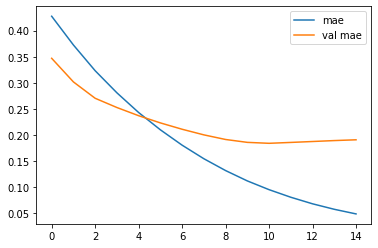

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 1s 7ms/step
2388.909 1.975244 3244.7958333306583


,actual,prediction
0,121050,117534.914062
1,120300,117534.914062
2,120050,117534.914062
3,119900,117534.914062
4,119500,117534.914062
...,...,...
229,119350,117538.984375
230,121850,117537.937500
231,124200,117538.335938
232,118800,117537.609375


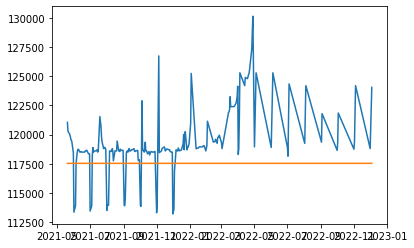

In [ ]:
prediction1_a = forecast_predict(model1, test_sapi2_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_sapi21_a = pd.DataFrame()
data_new_sapi21_a['actual'] = x_test
data_new_sapi21_a['prediction'] = data_result1_a
data_new_sapi21_a.to_csv('dagingsapi2_model2_sgd_type1.csv')

plt.plot(y_test, data_new_sapi21_a.actual)
plt.plot(y_test, data_new_sapi21_a.prediction)

data_new_sapi21_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0076 - mae: 0.0679 - mape: 538316.6875 - val_loss: 0.0564 - val_mae: 0.1926 - val_mape: 80.7000
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0078 - mae: 0.0687 - mape: 545139.5625 - val_loss: 0.0564 - val_mae: 0.1927 - val_mape: 80.8058
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0076 - mae: 0.0686 - mape: 548183.8750 - val_loss: 0.0564 - val_mae: 0.1930 - val_mape: 81.1259
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0077 - mae: 0.0685 - mape: 558706.4375 - val_loss: 0.0564 - val_mae: 0.1927 - val_mape: 80.6993
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0076 - mae: 0.0678 - mape: 545731.0625 - val_loss: 0.0564 - val_mae: 0.1928 - val_mape: 80.8336
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0075 - mae: 0.0665 - mape: 550619.8750 - val_loss: 0.0564 - val_

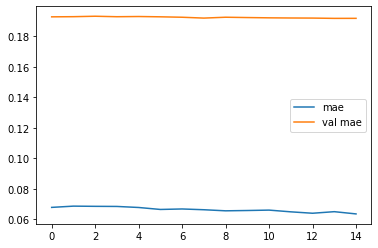

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
2536.6167 2.1003845 3231.296798500565


,actual,prediction
0,121050,115921.953125
1,120300,115924.546875
2,120050,115951.921875
3,119900,115970.906250
4,119500,116037.273438
...,...,...
229,119350,118205.687500
230,121850,118158.265625
231,124200,118155.132812
232,118800,118116.867188


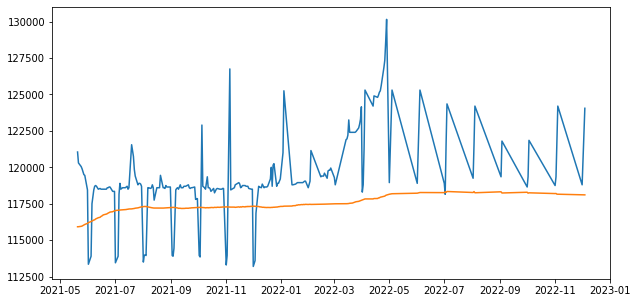

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_sapi2_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_sapi21_a1 = pd.DataFrame()
data_new_sapi21_a1['actual'] = x_test
data_new_sapi21_a1['prediction'] = data_result1_a1
data_new_sapi21_a1.to_csv('dagingsapi2_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_sapi21_a1.actual)
plt.plot(y_test, data_new_sapi21_a1.prediction)
data_new_sapi21_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0038 - mae: 0.0347 - mape: 1096303.7500 - val_loss: 0.0563 - val_mae: 0.1922 - val_mape: 79.7639
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0038 - mae: 0.0339 - mape: 1098524.5000 - val_loss: 0.0563 - val_mae: 0.1926 - val_mape: 80.3005
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0037 - mae: 0.0331 - mape: 1103876.7500 - val_loss: 0.0563 - val_mae: 0.1929 - val_mape: 80.6209
Epoch 4/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0037 - mae: 0.0327 - mape: 1108794.6250 - val_loss: 0.0563 - val_mae: 0.1930 - val_mape: 80.8451
Epoch 5/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0037 - mae: 0.0325 - mape: 1109888.8750 - val_loss: 0.0563 - val_mae: 0.1931 - val_mape: 80.8906
Epoch 6/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0037 - mae: 0.0324 - mape: 1109476.0000 - val_loss: 0.0563 - val_

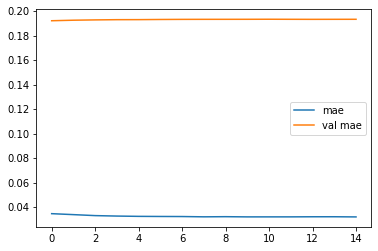

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
2303.0095 1.9063598 3060.2851174359557


,actual,prediction
0,121050,116167.031250
1,120300,116169.664062
2,120050,116197.320312
3,119900,116216.578125
4,119500,116283.601562
...,...,...
229,119350,118502.906250
230,121850,118453.820312
231,124200,118452.320312
232,118800,118412.406250


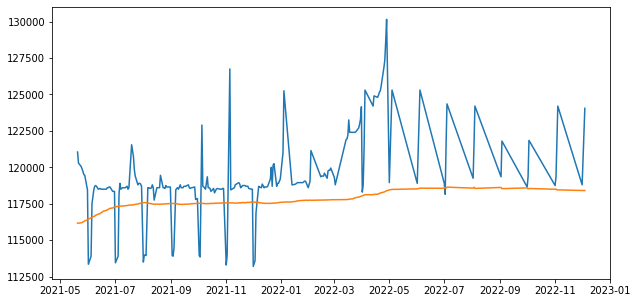

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_sapi2_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_sapi21_a2 = pd.DataFrame()
data_new_sapi21_a2['actual'] = x_test
data_new_sapi21_a2['prediction'] = data_result1_a2
data_new_sapi21_a2.to_csv('dagingsapi2_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_sapi21_a2.actual)
plt.plot(y_test, data_new_sapi21_a2.prediction)

data_new_sapi21_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9), loss='mean_squared_error', metrics=['mae'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=100, validation_data=val_step)

Epoch 1/100
44/44 [==============================] - 4s 35ms/step - loss: 0.2163 - mae: 0.4641 - val_loss: 0.2216 - val_mae: 0.4062
Epoch 2/100
44/44 [==============================] - 1s 15ms/step - loss: 0.2162 - mae: 0.4640 - val_loss: 0.2216 - val_mae: 0.4061
Epoch 3/100
44/44 [==============================] - 1s 14ms/step - loss: 0.2160 - mae: 0.4639 - val_loss: 0.2215 - val_mae: 0.4060
Epoch 4/100
44/44 [==============================] - 1s 14ms/step - loss: 0.2161 - mae: 0.4639 - val_loss: 0.2214 - val_mae: 0.4059
Epoch 5/100
44/44 [==============================] - 1s 14ms/step - loss: 0.2161 - mae: 0.4639 - val_loss: 0.2214 - val_mae: 0.4059
Epoch 6/100
44/44 [==============================] - 1s 14ms/step - loss: 0.2160 - mae: 0.4638 - val_loss: 0.2213 - val_mae: 0.4058
Epoch 7/100
44/44 [==============================] - 1s 14ms/step - loss: 0.2156 - mae: 0.4634 - val_loss: 0.2212 - val_mae: 0.4057
Epoch 8/100
44/44 [==============================] - 1s 14ms/step - loss: 0.

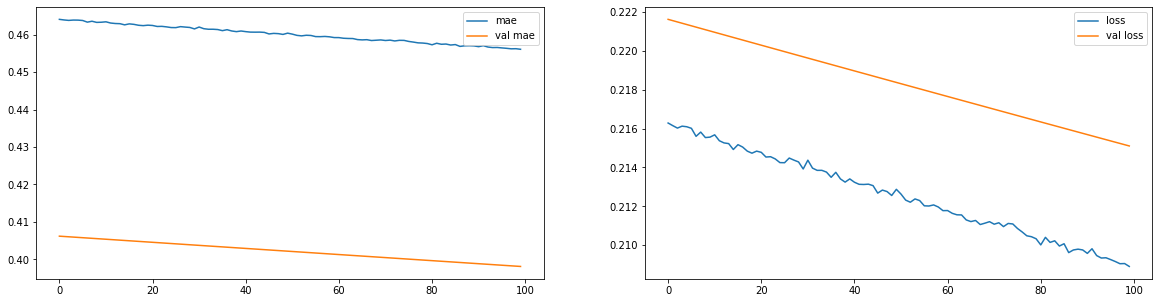

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
12557.584 10.475792 12835.230890015186


,actual,prediction
0,121050,106672.250000
1,120300,106672.078125
2,120050,106673.890625
3,119900,106677.695312
4,119500,106681.179688
...,...,...
229,119350,106908.515625
230,121850,106909.304688
231,124200,106915.460938
232,118800,106910.562500


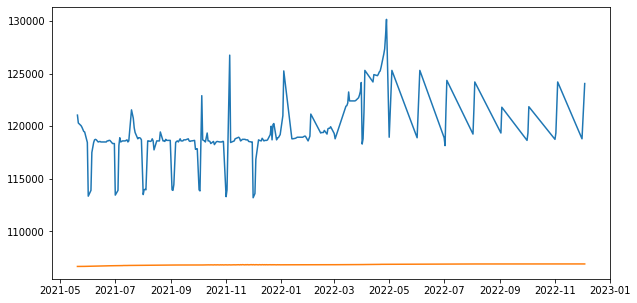

In [ ]:
prediction2 = forecast_predict(model2, test_sapi2_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_sapi22 = pd.DataFrame()
data_new_sapi22['actual'] = x_test
data_new_sapi22['prediction'] = data_result2
data_new_sapi22.to_csv('dagingsapi2_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_sapi22.actual)
plt.plot(y_test, data_new_sapi22.prediction)
data_new_sapi22

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 8ms/step - loss: 0.1539 - mae: 0.3799 - val_loss: 0.2142 - val_mae: 0.3970
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.1531 - mae: 0.3789 - val_loss: 0.2134 - val_mae: 0.3959
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.1524 - mae: 0.3779 - val_loss: 0.2125 - val_mae: 0.3948
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.1514 - mae: 0.3767 - val_loss: 0.2116 - val_mae: 0.3937
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.1507 - mae: 0.3757 - val_loss: 0.2107 - val_mae: 0.3926
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.1500 - mae: 0.3747 - val_loss: 0.2099 - val_mae: 0.3915
Epoch 7/50
718/718 [==============================] - 5s 7ms/step - loss: 0.1492 - mae: 0.3736 - val_loss: 0.2090 - val_mae: 0.3904
Epoch 8/50
718/718 [==============================] - 5s 7ms/step - loss: 0.

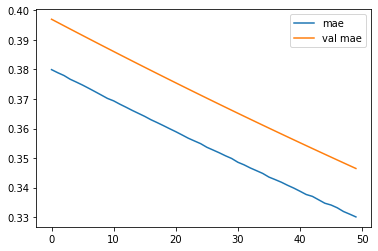

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_sapi2_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_sapi22_1 = pd.DataFrame()
data_new_sapi22_1['actual'] = x_test
data_new_sapi22_1['prediction'] = data_result2_1
data_new_sapi22_1.to_csv('dagingsapi2_model3_sgd_type2.csv')

data_new_sapi22

199/199 [==============================] - 1s 4ms/step
11383.792 9.491935 11690.103164643158


,actual,prediction
0,121050,106672.250000
1,120300,106672.078125
2,120050,106673.890625
3,119900,106677.695312
4,119500,106681.179688
...,...,...
229,119350,106908.515625
230,121850,106909.304688
231,124200,106915.460938
232,118800,106910.562500


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 12ms/step - loss: 0.1546 - mae: 0.3886 - val_loss: 0.1766 - val_mae: 0.3463
Epoch 2/50
84/84 [==============================] - 1s 10ms/step - loss: 0.1543 - mae: 0.3882 - val_loss: 0.1765 - val_mae: 0.3462
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1543 - mae: 0.3881 - val_loss: 0.1764 - val_mae: 0.3461
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1542 - mae: 0.3880 - val_loss: 0.1763 - val_mae: 0.3459
Epoch 5/50
84/84 [==============================] - 1s 10ms/step - loss: 0.1542 - mae: 0.3880 - val_loss: 0.1762 - val_mae: 0.3458
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1540 - mae: 0.3877 - val_loss: 0.1761 - val_mae: 0.3457
Epoch 7/50
84/84 [==============================] - 1s 10ms/step - loss: 0.1539 - mae: 0.3877 - val_loss: 0.1760 - val_mae: 0.3455
Epoch 8/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1538 - m

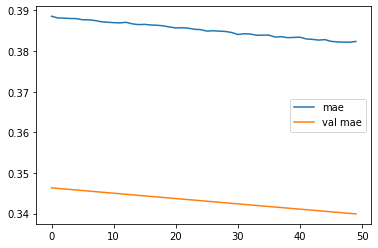

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_sapi2_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_sapi22_2 = pd.DataFrame()
data_new_sapi22_2['actual'] = x_test
data_new_sapi22_2['prediction'] = data_result2_2
data_new_sapi22_2.to_csv('dagingsapi2_model3_sgd_type3.csv')

data_new_sapi22_2

181/181 [==============================] - 1s 4ms/step
11157.476 9.30233 11468.886258046157


,actual,prediction
0,121050,108053.382812
1,120300,108053.765625
2,120050,108056.492188
3,119900,108062.289062
4,119500,108068.164062
...,...,...
229,119350,108321.367188
230,121850,108317.171875
231,124200,108310.085938
232,118800,108311.687500


### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 34ms/step - loss: 0.2141 - mae: 0.4613 - val_loss: 0.1966 - val_mae: 0.3744
Epoch 2/50
44/44 [==============================] - 1s 16ms/step - loss: 0.1235 - mae: 0.3397 - val_loss: 0.1005 - val_mae: 0.2482
Epoch 3/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0027 - mae: 0.0385 - val_loss: 0.0849 - val_mae: 0.2292
Epoch 4/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0010 - mae: 0.0204 - val_loss: 0.0855 - val_mae: 0.2300
Epoch 5/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0010 - mae: 0.0218 - val_loss: 0.0854 - val_mae: 0.2299
Epoch 6/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0010 - mae: 0.0206 - val_loss: 0.0853 - val_mae: 0.2297
Epoch 7/50
44/44 [==============================] - 1s 14ms/step - loss: 9.3095e-04 - mae: 0.0195 - val_loss: 0.0851 - val_mae: 0.2294
Epoch 8/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0010

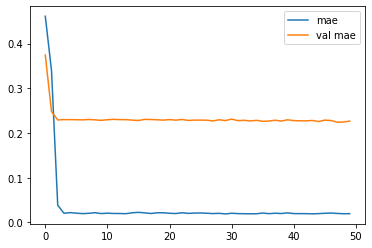

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_sapi2_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_sapi22_a = pd.DataFrame()
data_new_sapi22_a['actual'] = x_test
data_new_sapi22_a['prediction'] = data_result2_a
data_new_sapi22_a.to_csv('dagingsapi2_model3_adam_type1.csv')

data_new_sapi22_a

131/131 [==============================] - 1s 6ms/step
2379.3823 1.9693965 3121.9671683091096


,actual,prediction
0,121050,116277.484375
1,120300,116279.796875
2,120050,116295.914062
3,119900,116301.343750
4,119500,116309.726562
...,...,...
229,119350,118302.523438
230,121850,118316.015625
231,124200,118354.195312
232,118800,118324.859375


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0049 - mae: 0.0417 - val_loss: 0.0633 - val_mae: 0.1905
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0052 - mae: 0.0440 - val_loss: 0.0598 - val_mae: 0.1834
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0052 - mae: 0.0458 - val_loss: 0.0600 - val_mae: 0.1838
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0051 - mae: 0.0429 - val_loss: 0.0612 - val_mae: 0.1861
Epoch 5/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0049 - mae: 0.0430 - val_loss: 0.0590 - val_mae: 0.1827
Epoch 6/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0048 - mae: 0.0413 - val_loss: 0.0581 - val_mae: 0.1822
Epoch 7/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0050 - mae: 0.0431 - val_loss: 0.0629 - val_mae: 0.1903
Epoch 8/50
718/718 [==============================] - 5s 7ms/step - loss: 0.

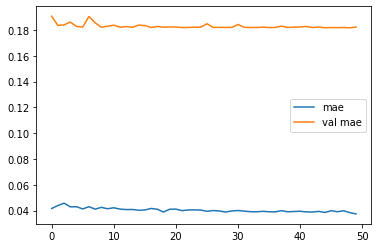

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
2221.7625 1.8431853 2960.1082750467085


,actual,prediction
0,121050,113626.460938
1,120300,113631.468750
2,120050,113795.640625
3,119900,113880.875000
4,119500,113908.218750
...,...,...
229,119350,120152.023438
230,121850,120203.679688
231,124200,120312.781250
232,118800,120210.554688


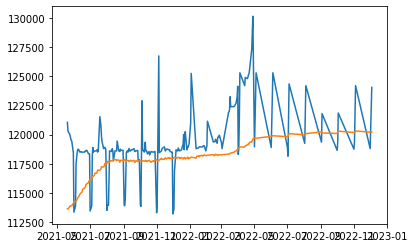

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_sapi2_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_sapi22_a1 = pd.DataFrame()
data_new_sapi22_a1['actual'] = x_test
data_new_sapi22_a1['prediction'] = data_result2_a1
data_new_sapi22_a1.to_csv('dagingsapi2_model3_adam_type2.csv')

plt.plot(y_test, data_new_sapi22_a1.actual)
plt.plot(y_test, data_new_sapi22_a1.prediction)
data_new_sapi22_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 100, validation_data=val_step)

Epoch 1/100
84/84 [==============================] - 1s 13ms/step - loss: 0.0037 - mae: 0.0320 - val_loss: 0.0573 - val_mae: 0.1815
Epoch 2/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0037 - mae: 0.0318 - val_loss: 0.0577 - val_mae: 0.1817
Epoch 3/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0037 - mae: 0.0317 - val_loss: 0.0572 - val_mae: 0.1814
Epoch 4/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0037 - mae: 0.0310 - val_loss: 0.0574 - val_mae: 0.1814
Epoch 5/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0037 - mae: 0.0315 - val_loss: 0.0576 - val_mae: 0.1815
Epoch 6/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0037 - mae: 0.0319 - val_loss: 0.0586 - val_mae: 0.1826
Epoch 7/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0037 - mae: 0.0333 - val_loss: 0.0582 - val_mae: 0.1820
Epoch 8/100
84/84 [==============================] - 1s 11ms/step - loss: 0.

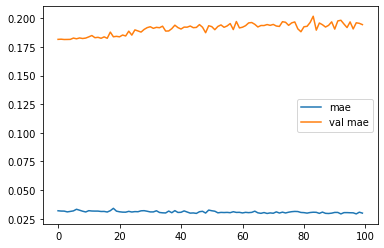

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

191/191 [==============================] - 1s 4ms/step
3152.4058 2.6127932 3837.27572634545


,actual,prediction
0,121050,113085.835938
1,120300,113034.453125
2,120050,113144.039062
3,119900,113164.015625
4,119500,113203.390625
...,...,...
229,119350,117394.046875
230,121850,117382.375000
231,124200,117390.500000
232,118800,117396.054688


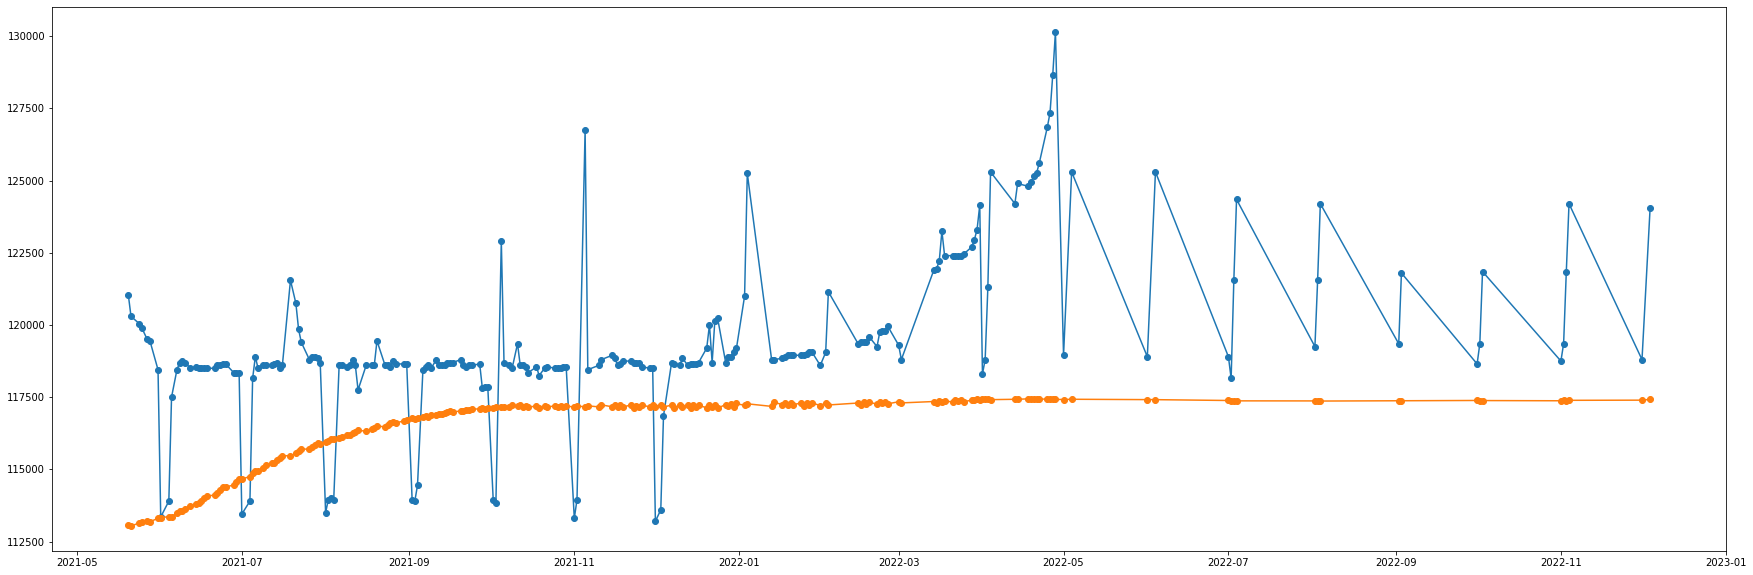

In [ ]:
win_size = 100
prediction2_a2 = forecast_predict(model2_a, test_sapi2_, time_size=win_size, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_sapi22_a2 = pd.DataFrame()
data_new_sapi22_a2['actual'] = x_test
data_new_sapi22_a2['prediction'] = data_result2_a2
data_new_sapi22_a2.to_csv('dagingsapi2_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_sapi22_a2.actual, '-o')
plt.plot(y_test,data_new_sapi22_a2.prediction, '-o')
data_new_sapi22_a2